In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from rdkit import Chem
from molmod import *

import os
import re
import gc
import openbabel

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy.cluster import hierarchy as hc
from scipy.stats import spearmanr
import lightgbm
import xgboost

# Predicting Molecular Properties

## 1. Introduction
This notebook details my participation in the "Predicting Molecular Properties" Kaggle competition. The goal is to predict the scalar coupling constant between two atoms in a molecule, given data about the position and type of each atom in the molecule. The scalar coupling constant can be derived exactly using quantum calculations. However, these are computationally very demanding and so the aim of the competition is to come up with a model that approximates the constant at a fraction of the time and computational requirements. The official evaluation metric is the natural logarithm of the mean absolute error.

## 2. Data Loading

In [2]:
test = pd.read_csv('test.csv')
test['scalar_coupling_constant'] = np.nan

structures = pd.read_csv('structures.csv')

df = pd.concat([pd.read_csv('train.csv'), test])
del test

df. head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074


In [3]:
structures.head()

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397


In [4]:
structures[structures.atom == 'C'].atom_index.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 17, 18, 12],
      dtype=int64)

## 3. Data Exploration

While there aren't many features to work with initially, it is always useful to gain an understanding of the data before we start manipulating it. Hopefully, we gain some direction in our efforts.

Let's take a look at the different bond types, plotted against the target value:

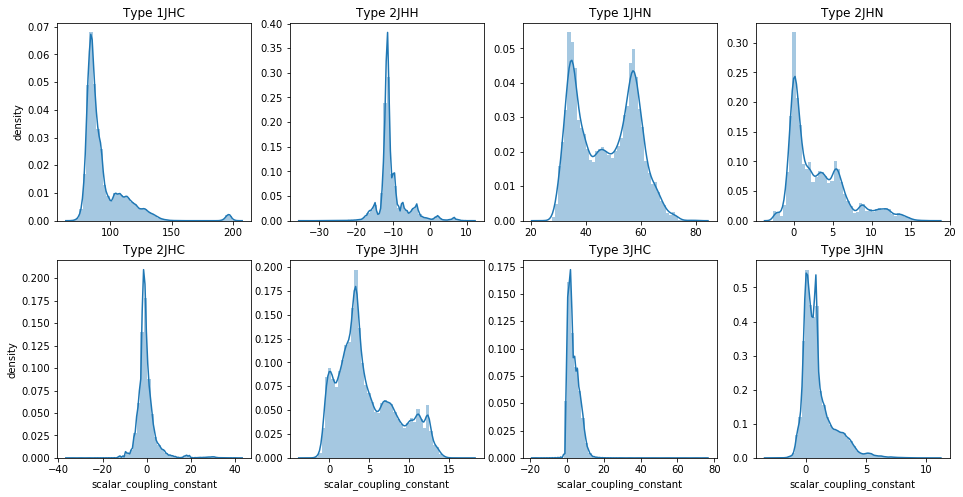

In [5]:
plt.figure(figsize = (16, 8))

i = 1
for typ in df.type.unique():
    plt.subplot(2, 4, i)
    
    if i in [1, 5]:
        plt.ylabel('density')
        
    if i > 4:
        plt.xlabel('scalar_coupling_constant')
    
    plt.title(f'Type {typ}')
    
    sns.distplot(df[(df.type == typ)&(~df.scalar_coupling_constant.isna())]['scalar_coupling_constant'].values,
                 50,
                 norm_hist=True)
    i += 1

It is obvious that the conditional distributions of the target value dependent on the bond type are wildly different. From this it can be assumed that training different models for each bond type might be useful and, indeed, this turns out to be the case. Furthermore, the different models would probably benefit from varying sets of features as well!

To conclude this (admittedly, very short) section on data exploration, let's take a look at the counts for each bond type:

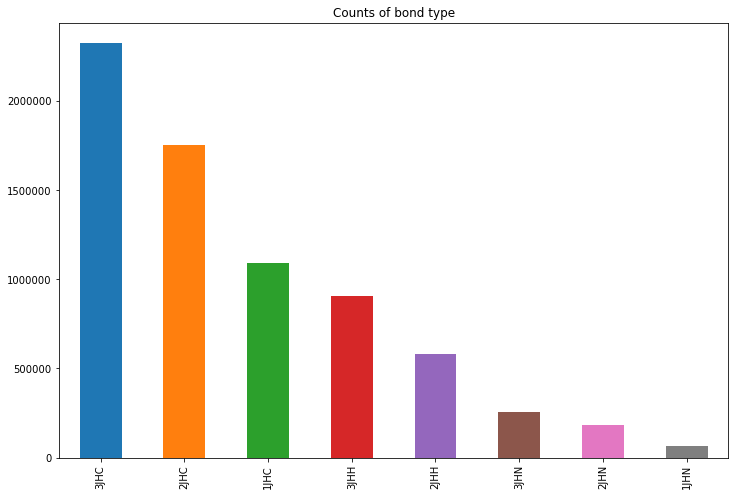

In [6]:
df['type'].value_counts().plot(kind = 'bar', figsize = (12, 8), title = 'Counts of bond type')

The bond types are not equally represented in the data set and we'd do well to keep this in mind as we go along.

## 4. Feature Engineering
   There are two main tables to work with here - the first one (in which I have combined training and test data...for now) contains data about the bonds: the atoms participating, type of bond and the most important column - the target value, *scalar_coupling_constant*. The second table, *structures*, contains 3D Cartesian coordinates of each atom in each molecule, both training and test data.
   
   Even at this stage, it is clear that feature engineering will play a central role in this competition. We have the 3D coordinates and the type of atoms to play around with below:


In [7]:
# copied from https://www.kaggle.com/kabure/lightgbm-full-pipeline-model
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    
    return df

In [8]:
atoms_counts = structures[['molecule_name', 'atom', 'atom_index']]\
                    .groupby(['molecule_name', 'atom'])\
                    .count()
        
atoms_counts['count'] = atoms_counts.atom_index
atoms_counts = atoms_counts.drop(['atom_index'], axis = 1).reset_index()

for atom in ['C', 'H', 'N', 'O', 'F']:
    col_name = 'n_' + atom
    atoms_counts[col_name] = atoms_counts[(atoms_counts.atom == atom)]['count']
    atoms_counts[col_name] = atoms_counts[col_name].fillna(0)
    atoms_counts[col_name] = atoms_counts[col_name].astype('int8')
    
atoms_counts = atoms_counts[['molecule_name', 'n_C', 'n_H', 'n_N', 'n_O', 'n_F']]\
                    .groupby('molecule_name')\
                    .sum().reset_index()

df = df.merge(atoms_counts, how='left', on='molecule_name')

structures['center_dist'] = np.sqrt(structures.x ** 2 + structures.y ** 2 + structures.z ** 2)

for atom_idx in [0, 1]:
    df = df.merge(structures, how='left',
                left_on=['molecule_name', f'atom_index_{atom_idx}'],
                right_on=['molecule_name', 'atom_index'])
    
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'center_dist': f'center_dist_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    
df = df.drop(['atom_index_x', 'atom_index_y'], axis = 1)

p_0 = df[['x_0', 'y_0', 'z_0']].values
p_1 = df[['x_1', 'y_1', 'z_1']].values
df['dist_x'] = ((df['x_0'] - df['x_1']) ** 2).astype('float16')
df['dist_y'] = ((df['y_0'] - df['y_1']) ** 2).astype('float16')
df['dist_z'] = ((df['z_0'] - df['z_1']) ** 2).astype('float16')

df['dist'] = np.linalg.norm(p_0 - p_1, axis=1).astype('float16')
del p_0, p_1    
    
df['atom_0_couples_count'] = df.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')\
                                .astype('int8')
df['atom_1_couples_count'] = df.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')\
                                .astype('int8')
df['n_atoms'] = (df['n_C'] + df['n_H'] + df['n_N'] + df['n_O'] + df['n_F']).astype('int8')
df['molecule_couples'] = df.groupby('molecule_name')['id'].transform('count').astype('int16')
df['type_0'] = df['type'].apply(lambda x: x[0]).astype('int8')

df['molecule_dist_mean'] = df.groupby(['molecule_name'])['dist'].transform('mean').astype('float16')
df['molecule_dist_std'] = df.groupby(['molecule_name'])['dist'].transform('std').astype('float16')
df['molecule_dist_min'] = df.groupby(['molecule_name'])['dist'].transform('min').astype('float16')
df['molecule_dist_max'] = df.groupby(['molecule_name'])['dist'].transform('max').astype('float16')
df['atom_0_dist_center_diff'] = (df['center_dist_0'] - df['dist']).transform('abs').astype('float16')
df['atom_1_dist_center_diff'] = (df['center_dist_1'] - df['dist']).transform('abs').astype('float16')
df['atom_0_x_1_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['x_1'].transform('mean').astype('float16')
df['atom_0_x_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['x_1'].transform('std').astype('float16')
df['atom_0_y_1_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('mean').astype('float16')
df['atom_0_y_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('std').astype('float16')
df['atom_0_z_1_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['z_1'].transform('mean').astype('float16')
df['atom_0_z_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['z_1'].transform('std').astype('float16')
df['atom_1_x_0_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['x_0'].transform('mean').astype('float16')
df['atom_1_x_0_std'] = df.groupby(['molecule_name', 'atom_index_1'])['x_0'].transform('std').astype('float16')
df['atom_1_y_0_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['y_0'].transform('mean').astype('float16')
df['atom_1_y_0_std'] = df.groupby(['molecule_name', 'atom_index_1'])['y_0'].transform('std').astype('float16')
df['atom_1_z_0_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['z_0'].transform('mean').astype('float16')
df['atom_1_z_0_std'] = df.groupby(['molecule_name', 'atom_index_1'])['z_0'].transform('std').astype('float16')
df['atom_0_x_1_diff'] = (df['atom_0_x_1_mean'] - df['x_1']).transform('abs').astype('float16')
df['atom_0_y_1_diff'] = (df['atom_0_y_1_mean'] - df['y_1']).transform('abs').astype('float16')
df['atom_0_z_1_diff'] = (df['atom_0_z_1_mean'] - df['z_1']).transform('abs').astype('float16')
df['atom_1_x_0_diff'] = (df['atom_1_x_0_mean'] - df['x_0']).transform('abs').astype('float16')
df['atom_1_y_0_diff'] = (df['atom_1_y_0_mean'] - df['y_0']).transform('abs').astype('float16')
df['atom_1_z_0_diff'] = (df['atom_1_z_0_mean'] - df['z_0']).transform('abs').astype('float16')
df['atom_0_dist_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('mean').astype('float16')
df['atom_0_dist_min'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min').astype('float16')
df['atom_0_dist_max'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('max').astype('float16')
df['atom_0_dist_std'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('std').astype('float16')#.fillna(0)
df['atom_1_dist_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('mean').astype('float16')
df['atom_1_dist_min'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('min').astype('float16')
df['atom_1_dist_max'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('max').astype('float16')
df['atom_1_dist_std'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('std').astype('float16')#.fillna(0)
df[f'atom_index_0_dist_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['dist']\
                                                    .transform('mean').astype('float16')
df[f'atom_index_0_dist_mean_diff'] = (df[f'atom_index_0_dist_mean'] - df['dist'])\
                                                    .transform('abs').astype('float16')
df[f'atom_index_0_dist_mean_div'] = (df[f'atom_index_0_dist_mean'] / df['dist']).astype('float16')
df[f'atom_index_0_dist_max'] = df.groupby(['molecule_name', 'atom_index_0'])['dist']\
                                                    .transform('max').astype('float16')
df[f'atom_index_0_dist_max_diff'] = (df[f'atom_index_0_dist_max'] - df['dist'])\
                                                    .transform('abs').astype('float16')
df[f'atom_index_0_dist_max_div'] = (df[f'atom_index_0_dist_max'] / df['dist']).astype('float16')
df[f'atom_index_0_dist_min'] = df.groupby(['molecule_name', 'atom_index_0'])['dist']\
                                                    .transform('min').astype('float16')
df[f'atom_index_0_dist_min_diff'] = (df[f'atom_index_0_dist_min'] - df['dist'])\
                                                    .transform('abs').astype('float16')
df[f'atom_index_0_dist_min_div'] = (df[f'atom_index_0_dist_min'] / df['dist']).astype('float16')
df[f'atom_index_0_dist_std'] = df.groupby(['molecule_name', 'atom_index_0'])['dist']\
                                                    .transform('std').astype('float16')
df[f'atom_index_0_dist_std_diff'] = (df[f'atom_index_0_dist_std'] - df['dist'])\
                                                    .transform('abs').astype('float16')
df[f'atom_index_0_dist_std_div'] = (df[f'atom_index_0_dist_std'] / df['dist']).astype('float16')
df[f'atom_index_1_dist_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['dist']\
                                                    .transform('mean').astype('float16')
df[f'atom_index_1_dist_mean_diff'] = (df[f'atom_index_1_dist_mean'] - df['dist'])\
                                                    .transform('abs').astype('float16')
df[f'atom_index_1_dist_mean_div'] = (df[f'atom_index_1_dist_mean'] / df['dist']).astype('float16')
df[f'atom_index_1_dist_max'] = df.groupby(['molecule_name', 'atom_index_1'])['dist']\
                                                    .transform('max').astype('float16')
df[f'atom_index_1_dist_max_diff'] = (df[f'atom_index_1_dist_max'] - df['dist'])\
                                                    .transform('abs').astype('float16')
df[f'atom_index_1_dist_max_div'] = (df[f'atom_index_1_dist_max'] / df['dist']).astype('float16')
df[f'atom_index_1_dist_min'] = df.groupby(['molecule_name', 'atom_index_1'])['dist']\
                                                    .transform('min').astype('float16')
df[f'atom_index_1_dist_min_diff'] = (df[f'atom_index_1_dist_min'] - df['dist'])\
                                                    .transform('abs').astype('float16')
df[f'atom_index_1_dist_min_div'] = (df[f'atom_index_1_dist_min'] / df['dist']).astype('float16')
df[f'atom_index_1_dist_std'] = df.groupby(['molecule_name', 'atom_index_1'])['dist']\
                                                    .transform('std').astype('float16')
df[f'atom_index_1_dist_std_diff'] = (df[f'atom_index_1_dist_std'] - df['dist'])\
                                                    .transform('abs').astype('float16')
df[f'atom_index_1_dist_std_div'] = (df[f'atom_index_1_dist_std'] / df['dist']).astype('float16')
df[f'atom_1_dist_min_diff'] = (df[f'atom_1_dist_min'] - df['dist']).transform('abs').astype('float16')
df[f'atom_1_dist_min_div'] = (df[f'atom_1_dist_min'] / df['dist']).astype('float16')
df[f'atom_1_dist_std_diff'] = (df[f'atom_1_dist_std'] - df['dist']).transform('abs').astype('float16')
df[f'type_0_dist_std'] = df.groupby(['molecule_name', 'type_0'])['dist'].transform('std')
df[f'type_0_dist_std_diff'] = (df[f'type_0_dist_std'] - df['dist']).transform('abs').astype('float16')
df[f'type_dist_mean'] = df.groupby(['molecule_name', 'type'])['dist'].transform('mean').astype('float16')
df[f'type_dist_mean_diff'] = (df[f'type_dist_mean'] - df['dist']).transform('abs').astype('float16')
df[f'type_dist_mean_div'] = (df[f'type_dist_mean'] / df['dist']).astype('float16')
df[f'type_dist_max'] = df.groupby(['molecule_name', 'type'])['dist'].transform('max').astype('float16')
df[f'type_dist_min'] = df.groupby(['molecule_name', 'type'])['dist'].transform('min').astype('float16')
df[f'type_dist_std'] = df.groupby(['molecule_name', 'type'])['dist'].transform('std').astype('float16')
df[f'type_dist_std_diff'] = (df[f'type_dist_std'] - df['dist']).transform('abs').astype('float16')

In [9]:
df = reduce_mem_usage(df)

Mem. usage decreased to 1816.17 Mb (21.3% reduction)


I got the features in the cell below from this kernel: https://www.kaggle.com/robertburbidge/atomic-properties.

In [10]:
atomic_radius = {'H': 0.38, 'C': 0.77, 'N': 0.75, 'O': 0.73, 'F': 0.71, np.nan: 0}
atomic_number = {'H': 1, 'C': 6, 'N': 7, 'O': 8, 'F': 9, np.nan: 0}
ionization_energy = {'H': 13.5984, 'C': 11.2603, 'N': 14.5341, 'O': 13.6181, 'F': 17.4228, np.nan: np.inf}

def atom_props(df):
    for num in [0, 1]:
        df[f'atom_{num}_rad'] = df[f'atom_{num}'].apply(lambda x: atomic_radius[x]).astype('float16')
        df[f'atom_{num}_num'] = df[f'atom_{num}'].apply(lambda x: atomic_number[x]).astype('int8')
        df[f'atom_{num}_ionen'] = df[f'atom_{num}'].apply(lambda x: ionization_energy[x]).astype('float16')
    return df

In [11]:
df = atom_props(df)

Looking through the discussions and various kernels of the competition, I found the molmod library, which allowed me to create center-of-mass and inertia features. The process of extracting the features is commented out, and it is loaded straight from a csv file to save time.

In [12]:
# STRUCTURES_PATH = 'structures/'
# filenames = next(iter(os.walk(STRUCTURES_PATH)))[2]
# mols = []
# for filename in filenames:
#     mol_name = filename.split('.')[0]
#     mol = Molecule.from_file(STRUCTURES_PATH + filename)
#     coords = np.array([])
#     with open(STRUCTURES_PATH + filename) as fp:
#         mol_data = fp.read()
#         arr = np.array(re.sub(r'[a-df-zA-Z\\]+', '', mol_data).strip().split(), dtype='float16')[1:]
#         try:
#             coords = arr.reshape(-1, 3)
#         except:
#             print(mol_name)
#             print(arr.shape)
#             print(arr)
#             break
    
#         mol.coordinates = coords
        
#     mol.set_default_masses()
#     mols.append({'molecule_name': mol_name,
#                  'com_x': mol.com[0],
#                  'com_y': mol.com[1],
#                  'com_z': mol.com[2],
#                  'inertias_len_mean': np.mean(list(map(np.linalg.norm, mol.inertia_tensor))),
#                  'inertias_len_std': np.std(list(map(np.linalg.norm, mol.inertia_tensor)))})

mass_inertia_df = pd.read_csv('mass_inertia_features.csv')
df = df.merge(mass_inertia_df, how='left', on='molecule_name')

df['atom_0_com_dist'] = np.linalg.norm(df[['x_0', 'y_0', 'z_0']] - df[['com_x', 'com_y', 'com_z']].values,
                                       axis = 1).astype('float16')
df['atom_1_com_dist'] = np.linalg.norm(df[['x_1', 'y_1', 'z_1']] - df[['com_x', 'com_y', 'com_z']].values,
                                       axis = 1).astype('float16')

del mass_inertia_df
gc.collect()

591

Another library, OpenBabel, I found in the kernel https://www.kaggle.com/jmtest/molecule-with-openbabel. I also got the code for extracting some angular features from this kernel.

Some of these are inapplicable (or just not useful) for certain interaction types. For example, the dihedral angle (*Torsion* column) only makes sense when considering interactions through three bonds (3J-types), while hybridization (*sp*) has by far the largest effect on 1J-type bonds. The features are only calculated for the bond types where they are applicable. Again, as above, the actual process of extracting the features is commented out as the data was preprocessed. All that's left now is to load a csv file.

In [25]:
# %%time
# obConversion = openbabel.OBConversion()
# obConversion.SetInFormat("xyz")

# structdir='structures/'
# mols=[]
# mols_files=os.listdir(structdir)
# mols_index=dict(map(reversed,enumerate(mols_files)))
# for f in mols_index.keys():
#     mol = openbabel.OBMol()
#     obConversion.ReadFile(mol, structdir+f) 
#     mols.append(mol)

Wall time: 9min 52s


In [ ]:
# def Atoms(molname,AtomId1,AtomId2):
#     mol=mols[mols_index[molname+'.xyz']]
#     return mol, mol.GetAtomById(AtomId1), mol.GetAtomById(AtomId2)

# def SecondAtom(bond,FirstAtom):
#     if FirstAtom.GetId()==bond.GetBeginAtom().GetId(): return bond.GetEndAtom()
#     else: return bond.GetBeginAtom()

# def Angle2J(molname,AtomId1,AtomId2,debug=False):
#     mol, firstAtom, lastAtom = Atoms(molname, AtomId1, AtomId2)
    
#     if debug: print (mol.GetFormula())
#     if debug: print(firstAtom.GetType(),firstAtom.GetId(),':',lastAtom.GetType(),lastAtom.GetId())
        
#     for b in openbabel.OBAtomBondIter(firstAtom): # all bonds for first atom
#         secondAtom=SecondAtom(b,firstAtom)
#         lastBond=secondAtom.GetBond(lastAtom)
#         if lastBond: # found!
#             if debug: print('middle',secondAtom.GetId(),secondAtom.GetType())
#             return firstAtom.GetAngle(secondAtom,lastAtom)
        
# def Torsion3J(molname,AtomId1,AtomId2,debug=False):
#     mol,firstAtom,lastAtom=Atoms(molname,AtomId1,AtomId2)
    
#     if debug: print (molname, mol.GetFormula())
#     if debug: print(firstAtom.GetType(),firstAtom.GetId(),':',lastAtom.GetType(),lastAtom.GetId())
        
#     for b in openbabel.OBAtomBondIter(firstAtom): # all bonds for first atom
#         secondAtom=SecondAtom(b,firstAtom)
#         for b2 in openbabel.OBAtomBondIter(secondAtom): # all bonds for second atom 
#             thirdAtom=SecondAtom(b2,secondAtom)
#             lastBond=thirdAtom.GetBond(lastAtom)
#             if lastBond: # found!
#                 if debug:
#                     print(secondAtom.GetType(),
#                           secondAtom.GetId(),'<->',
#                           thirdAtom.GetType(),
#                           thirdAtom.GetId())

#                 return mol.GetTorsion(firstAtom, secondAtom, thirdAtom, lastAtom)

In [13]:
# for t in train['type'].unique():
#     print(f'Type {t}')
#     b=int(t[0]) # current bond for this type

#     X = df[df.type==t]
#     X_ind = X.index.tolist()
#     if (b==1):
#         df.loc[X_ind, 'sp']=X.apply(lambda row: Atoms(row.molecule_name, row.atom_index_0, row.atom_index_1)[2].GetHyb(),axis=1).astype('float16') # second atom is C or N for bond 1
#     if (b==2):
#         df.loc[X_ind, 'Angle']=X.apply(lambda row: Angle2J(row.molecule_name , row.atom_index_0, row.atom_index_1),axis=1).astype('float16')
#     if (b==3):
#         df.loc[X_ind, 'Torsion']=X.apply(lambda row: Torsion3J(row.molecule_name , row.atom_index_0, row.atom_index_1),axis=1).astype('float16') 
#         df.loc[X_ind, 'cosT']=np.cos(np.deg2rad(df[df.index.isin(X_ind)]['Torsion'])).astype('float16')
#         df.loc[X_ind, 'cos2T']=np.cos(2*np.deg2rad(df[df.index.isin(X_ind)]['Torsion'])).astype('float16')

angle_df = pd.read_csv('angle_features.csv')
df = df.merge(angle_df, how='left', on='id')

df = df.drop(['Unnamed: 0_x', 'Unnamed: 0_y'], axis = 1)

del angle_df
gc.collect()

55

Some more angle features are added below:

In [10]:
# def map_atom_info(df_1,df_2, atom_idx):
#     df = pd.merge(df_1, df_2, how = 'left',
#                   left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
#                   right_on = ['molecule_name',  'atom_index'])
#     df = df.drop('atom_index', axis=1)

#     return df

# def create_closest(df):
#     #I apologize for my poor coding skill. Please make the better one.
#     df_temp = df.loc[:,["molecule_name","atom_index_0","atom_index_1","dist","x_0","y_0","z_0","x_1","y_1","z_1"]].copy()
#     df_temp_ = df_temp.copy()
#     df_temp_ = df_temp_.rename(columns={'atom_index_0': 'atom_index_1',
#                                        'atom_index_1': 'atom_index_0',
#                                        'x_0': 'x_1',
#                                        'y_0': 'y_1',
#                                        'z_0': 'z_1',
#                                        'x_1': 'x_0',
#                                        'y_1': 'y_0',
#                                        'z_1': 'z_0'})
#     df_temp = pd.concat(objs=[df_temp,df_temp_],axis=0)

#     df_temp["min_distance"] = df_temp.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
#     df_temp = df_temp[df_temp["min_distance"]==df_temp["dist"]]

#     df_temp = df_temp.drop(['x_0','y_0','z_0','min_distance'], axis=1)
#     df_temp = df_temp.rename(columns={'atom_index_0': 'atom_index',
#                                      'atom_index_1': 'atom_index_closest',
#                                      'distance': 'distance_closest',
#                                      'x_1': 'x_closest',
#                                      'y_1': 'y_closest',
#                                      'z_1': 'z_closest'})

#     for atom_idx in [0,1]:
#         df = map_atom_info(df,df_temp, atom_idx)
#         df = df.rename(columns={'atom_index_closest': f'atom_index_closest_{atom_idx}',
#                                             'distance_closest': f'distance_closest_{atom_idx}',
#                                             'x_closest': f'x_closest_{atom_idx}',
#                                             'y_closest': f'y_closest_{atom_idx}',
#                                             'z_closest': f'z_closest_{atom_idx}'})
#     return df

# def add_cos_features(df):
#     df["distance_0"]=(((df['x_0']-df['x_closest_0'])**2+(df['y_0']-df['y_closest_0'])**2+(df['z_0']-df['z_closest_0'])**2)**(1/2)).astype('float16')
#     df["distance_1"]=(((df['x_1']-df['x_closest_1'])**2+(df['y_1']-df['y_closest_1'])**2+(df['z_1']-df['z_closest_1'])**2)**(1/2)).astype('float16')
#     df["vec_0_x"]=((df['x_0']-df['x_closest_0'])/df["distance_0"]).astype('float16')
#     df["vec_0_y"]=(df['y_0']-df['y_closest_0'])/df["distance_0"].astype('float16')
#     df["vec_0_z"]=(df['z_0']-df['z_closest_0'])/df["distance_0"].astype('float16')
#     df["vec_1_x"]=(df['x_1']-df['x_closest_1'])/df["distance_1"].astype('float16')
#     df["vec_1_y"]=(df['y_1']-df['y_closest_1'])/df["distance_1"].astype('float16')
#     df["vec_1_z"]=(df['z_1']-df['z_closest_1'])/df["distance_1"].astype('float16')
#     df["vec_x"]=(df['x_1']-df['x_0'])/df["dist"].astype('float16')
#     df["vec_y"]=(df['y_1']-df['y_0'])/df["dist"].astype('float16')
#     df["vec_z"]=(df['z_1']-df['z_0'])/df["dist"].astype('float16')
#     df["cos_0_1"]=(df["vec_0_x"]*df["vec_1_x"]+df["vec_0_y"]*df["vec_1_y"]+df["vec_0_z"]*df["vec_1_z"]).astype('float16')
#     df["cos_0"]=(df["vec_0_x"]*df["vec_x"]+df["vec_0_y"]*df["vec_y"]+df["vec_0_z"]*df["vec_z"]).astype('float16')
#     df["cos_1"]=(df["vec_1_x"]*df["vec_x"]+df["vec_1_y"]*df["vec_y"]+df["vec_1_z"]*df["vec_z"]).astype('float16')
#     df=df.drop(['vec_0_x','vec_0_y','vec_0_z','vec_1_x','vec_1_y','vec_1_z','vec_x','vec_y','vec_z'], axis=1)
#     return df

In [12]:
# df = create_closest(df)
# df = add_cos_features(df)

cos_features = pd.read_csv('cos_features.csv')
df = df.merge(cos_features, on='id', how='left')

del cos_features
gc.collect()

In [14]:
df.atom_0.unique()

array(['H'], dtype=object)

In [15]:
df.atom_1.unique()

array(['C', 'H', 'N'], dtype=object)

As can be seen from the two cells above, the *atom_1* only ever takes a few values, while *atom_0* is always a hydrogen atom. Therefore, I can safely remove the latter column and encode the former. The choices are between creating dummy features for each value that *atom_1* can take, or use label encoding. Since the dataset is big and is already overloaded with columns, I decided that label encoding was the better option.

In [16]:
# df = pd.get_dummies(df.drop(['id', 'molecule_name', 'atom_0'], axis = 1))

lbl = LabelEncoder()
lbl.fit(list(df['atom_1'].values))
df['atom_1'] = lbl.transform(list(df['atom_1'].values))
df = df.drop(['id', 'molecule_name', 'atom_0'], axis = 1)

In [17]:
df = reduce_mem_usage(df)

Mem. usage decreased to 1625.97 Mb (23.0% reduction)


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7163689 entries, 0 to 7163688
Columns: 113 entries, atom_index_0 to cos2T
dtypes: float16(95), float32(2), int16(1), int8(14), object(1)
memory usage: 1.5+ GB


## 5. Adversarial Validation

The dataset now contains a whole bunch of features. While the type of model I will be using (i.e. gradient boosting) deals well high feature correlation, some of the columns might yet be harmful when it comes to good generalization.

The validation set should be as good a representation of the test set as possible. Ideally, they should have the same distribution. An easy way to assess and visualize validation vs test similarity is to train a model to distinguish between them. I guess this is one case in machine learning where we hope that the model does poorly! We can train a model and then plot feature importance to see which features helped the most. If the model managed to separate the two data sets well, then we can easily see which features are to blame.

In [47]:
def feature_importance_todf(model, columns, fi = None):
    feature_importance = pd.DataFrame()
    feature_importance['feature'] = columns
    feature_importance['importance'] = model.feature_importance() if fi is None else fi
    return feature_importance

def plot_feature_importance(model = None, data = None, model_type = None, fi = None, columns = None):
    cols = data.columns if columns is None else columns
    feature_importance = feature_importance_todf(model, cols, fi)

    plt.figure(figsize=(16, 12));    
    sns.barplot(x = "importance", 
                y = "feature",
                data=feature_importance.sort_values(by="importance", ascending=False));
    plt.title(f'Feature importance for model for type {model_type}');

Preparing adversarial validation for type 1JHC:


D:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training until validation scores don't improve for 250 rounds.
[500]	training's auc: 0.982415	valid_1's auc: 0.691958
[1000]	training's auc: 0.998823	valid_1's auc: 0.72066
[1500]	training's auc: 0.999947	valid_1's auc: 0.735462
[2000]	training's auc: 0.999998	valid_1's auc: 0.750182
[2500]	training's auc: 1	valid_1's auc: 0.761763
[3000]	training's auc: 1	valid_1's auc: 0.771153
[3500]	training's auc: 1	valid_1's auc: 0.779175
Early stopping, best iteration is:
[3608]	training's auc: 1	valid_1's auc: 0.780645
Preparing adversarial validation for type 2JHH:
Training until validation scores don't improve for 250 rounds.
[500]	training's auc: 0.990429	valid_1's auc: 0.603308
[1000]	training's auc: 0.999805	valid_1's auc: 0.619066
[1500]	training's auc: 0.999999	valid_1's auc: 0.627999
[2000]	training's auc: 1	valid_1's auc: 0.636427
Early stopping, best iteration is:
[2000]	training's auc: 1	valid_1's auc: 0.636427
Preparing adversarial validation for type 1JHN:
Training until validation

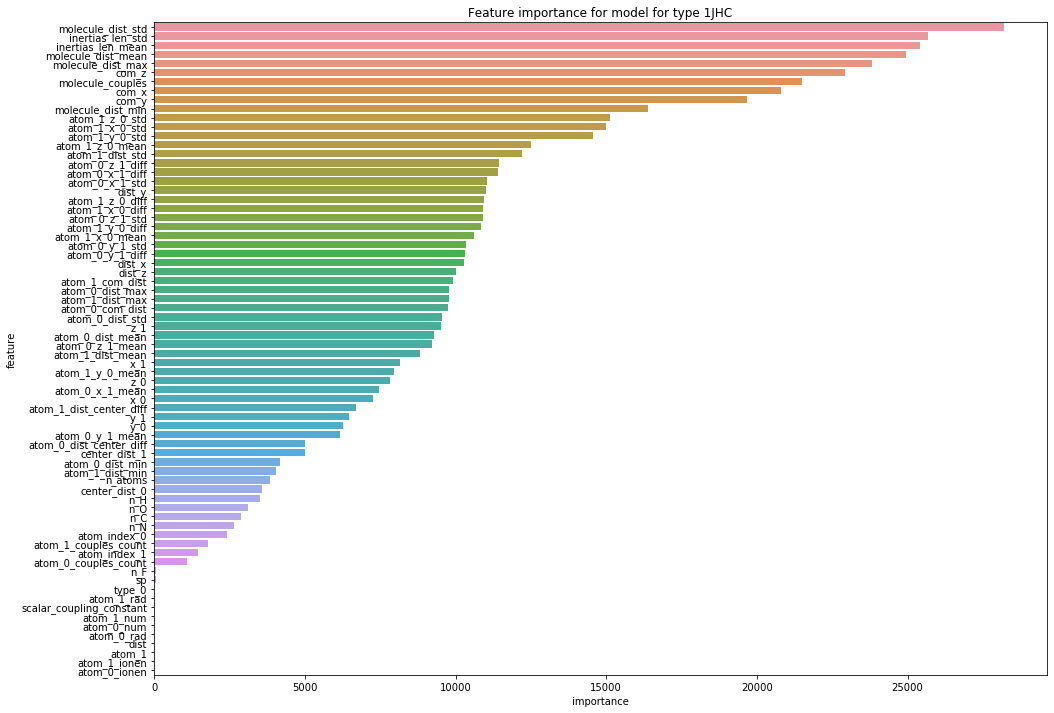

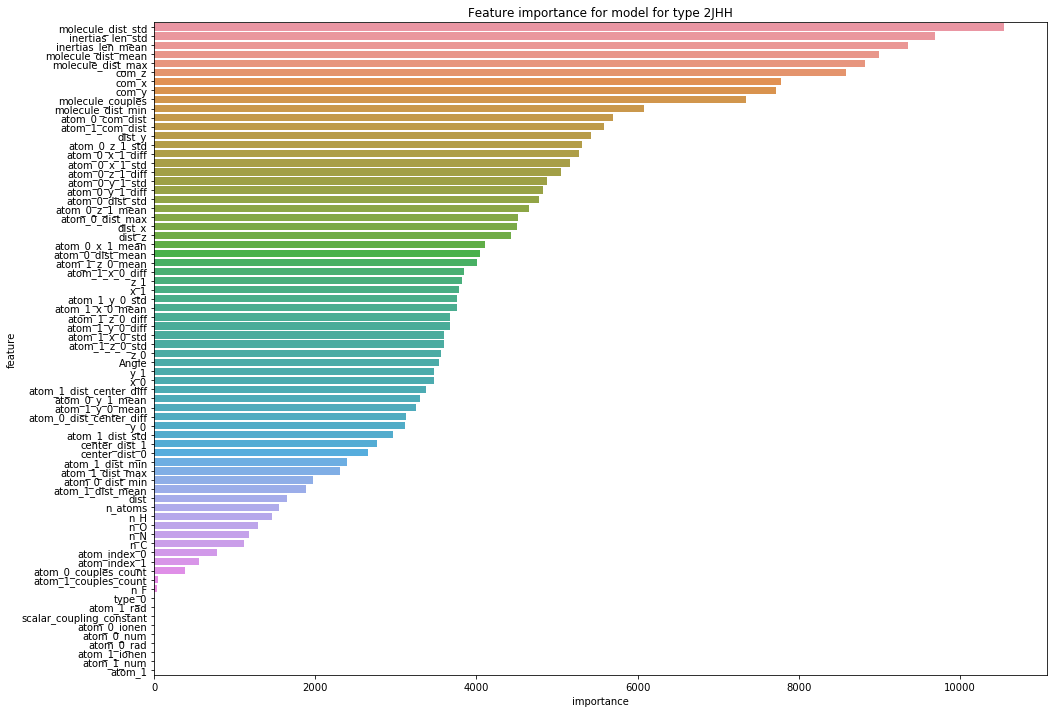

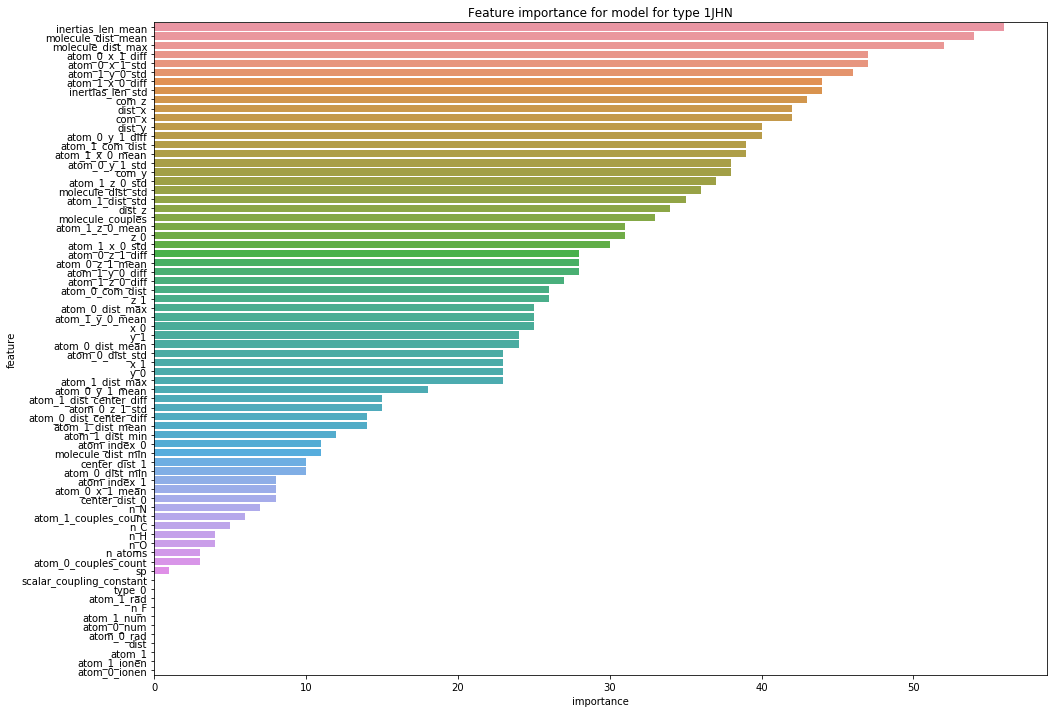

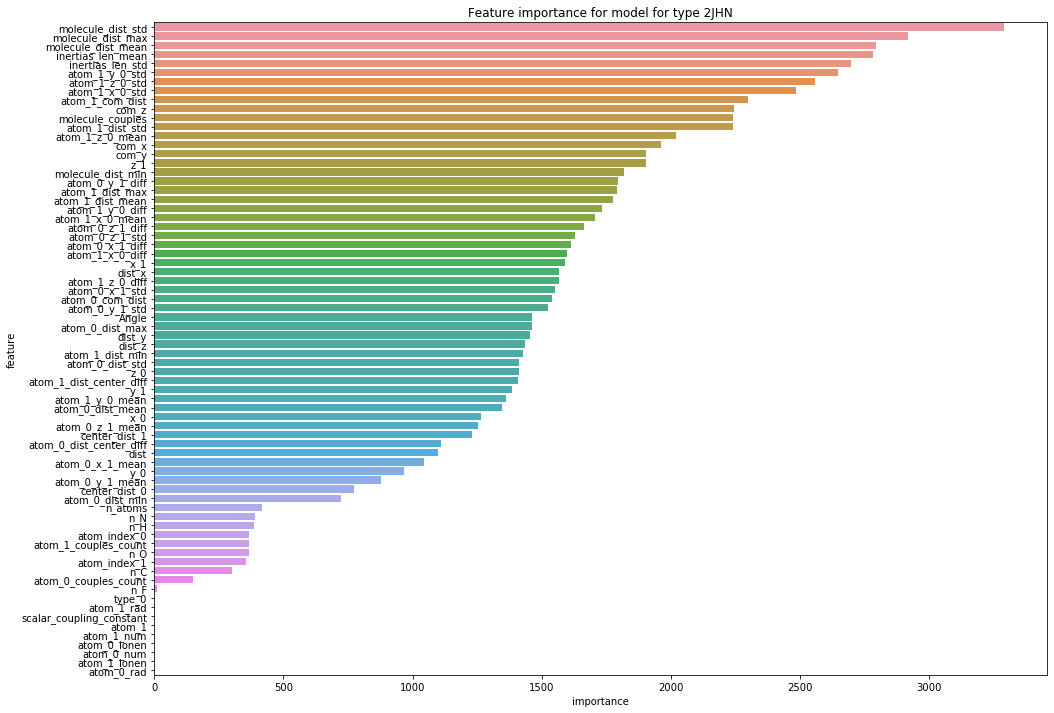

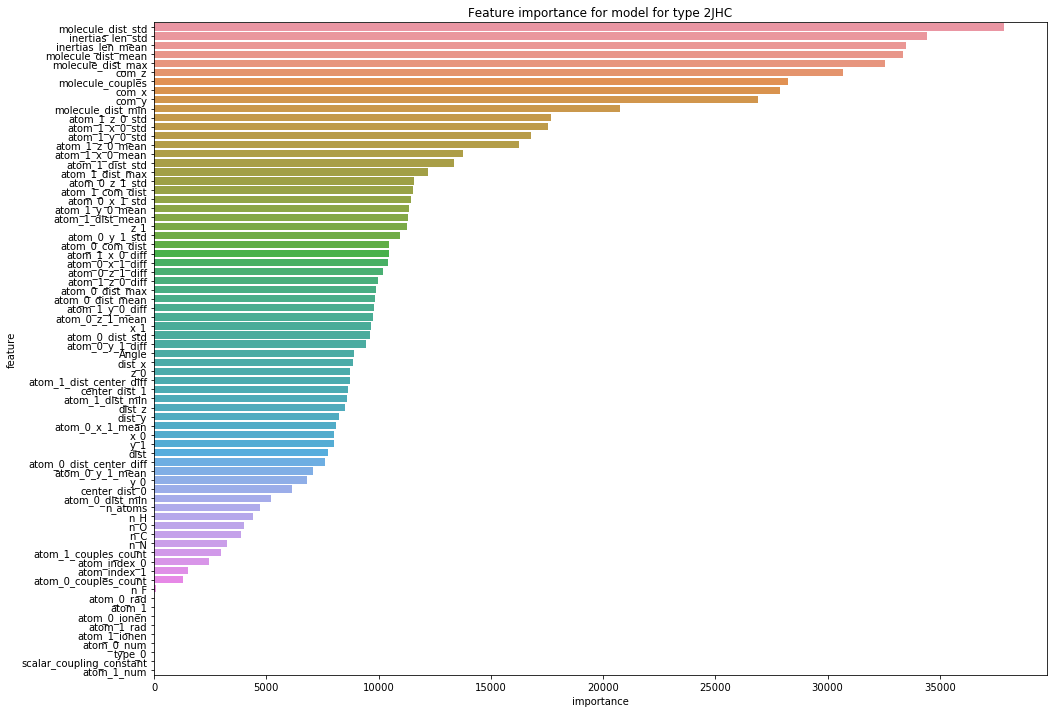

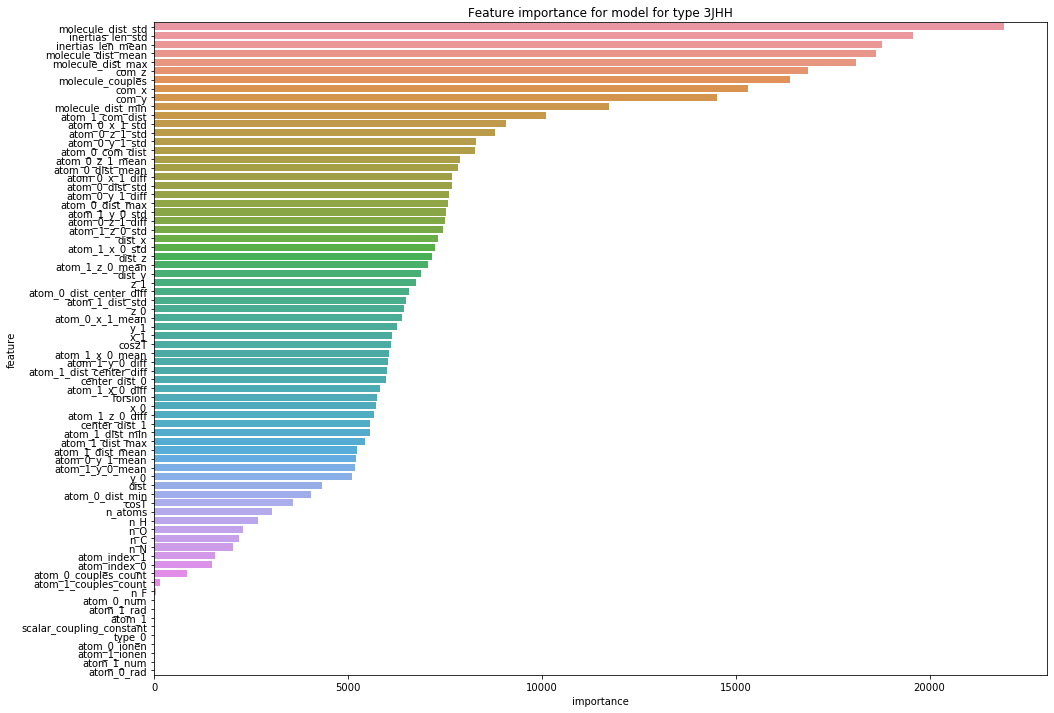

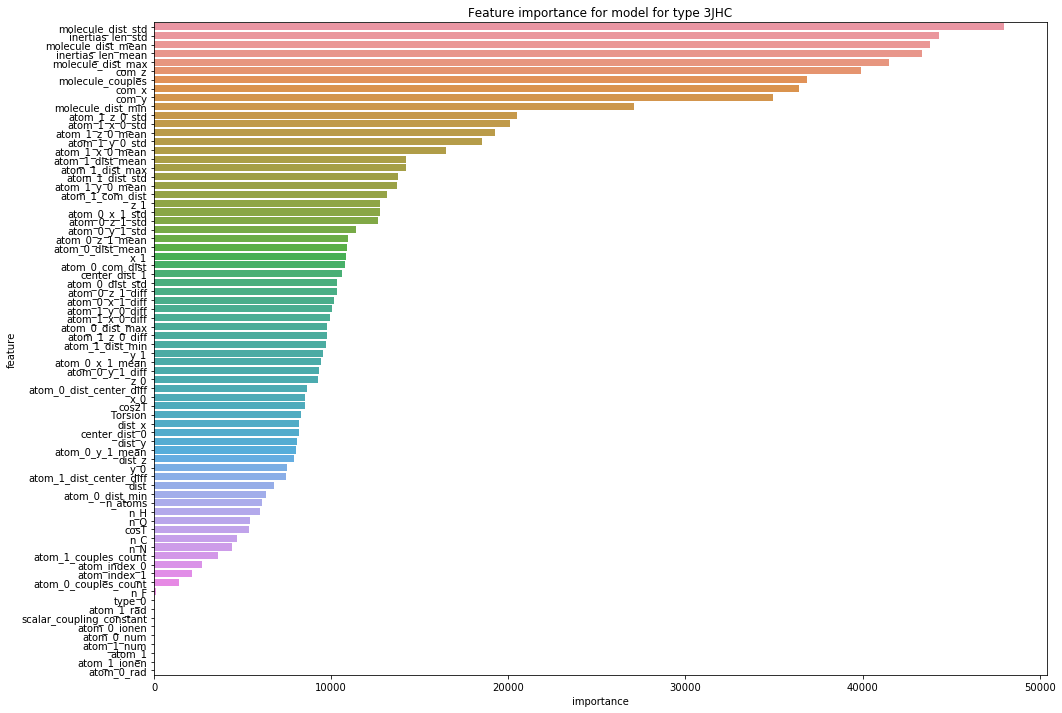

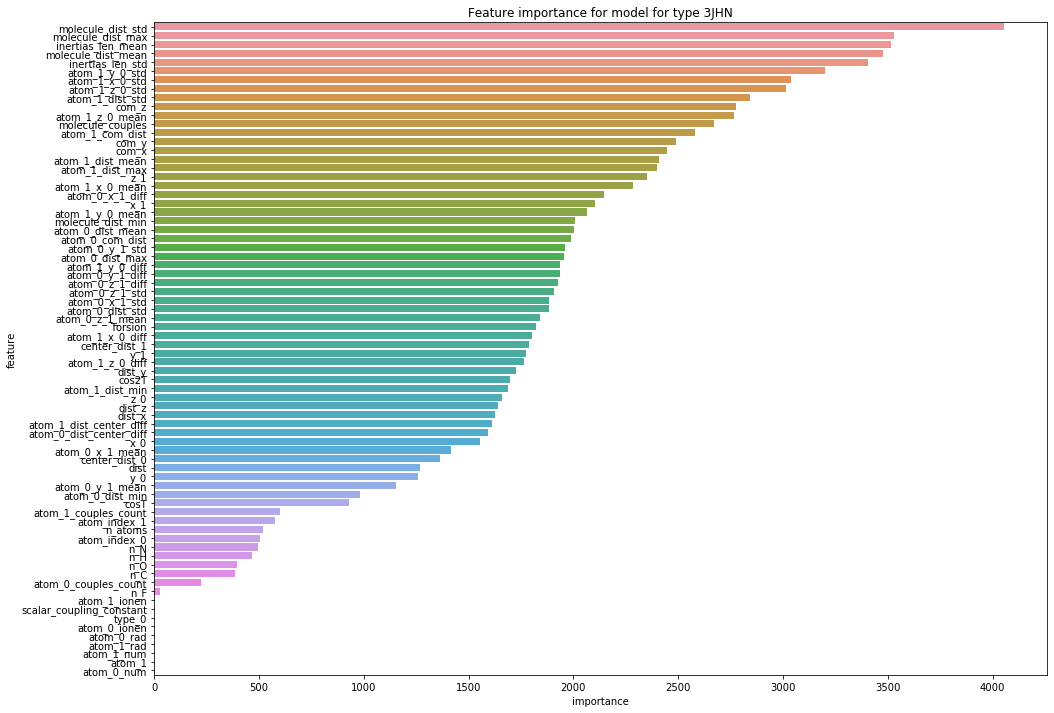

In [57]:
train = df[~df.scalar_coupling_constant.isna()]
test = df[df.scalar_coupling_constant.isna()]

models = []
for t in df['type'].unique():
    print(f'Preparing adversarial validation for type {t}:')
    
    train_type = train[train.type == t].drop('scalar_coupling_constant', axis = 1)
    y_train_type = train[train.type == t]['scalar_coupling_constant']
    
    if t[0] == '1':
        X_type = train_type.drop(['type', 'Angle', 'Torsion', 'cosT', 'cos2T'], axis = 1)        
        test_type = test[test.type == t].drop(['type', 'Angle', 'Torsion', 'cosT', 'cos2T'], axis = 1)
    elif t[0] == '2':
        X_type = train_type.drop(['type', 'sp', 'Torsion', 'cosT', 'cos2T'], axis = 1)
        test_type = test[test.type == t].drop(['type', 'sp', 'Torsion', 'cosT', 'cos2T'], axis = 1)
    else:
        X_type = train_type.drop(['type', 'sp', 'Angle'], axis = 1)
        test_type = test[test.type == t].drop(['type', 'sp', 'Angle'], axis = 1)
        
    X_train, X_val, y_train, y_val = train_test_split(X_type, 
                                                      y_train_type, 
                                                      test_size = 0.10, random_state = 21)
      
    params = {
        'boosting': 'gbdt',
        'feature_fraction': 1.0, 
        'learning_rate': 0.1,
        'max_depth': 9,
        'metric': 'auc',
        'min_child_samples': 80,
        'num_leaves': 500,
        'objective': 'binary',
        'reg_alpha': 0.5,
        'reg_lambda': 2.2,
        'bagging_fraction': 0.5
    }
    
    X_val['target'] = 0
    test_type['target'] = 1
    train_test = pd.concat([X_val, test_type], axis = 0)
    
    adv_train, adv_val, adv_train_y, adv_val_y = train_test_split(train_test.drop('target', axis = 1), 
                                                      train_test['target'], 
                                                      test_size = 0.25, random_state = 21)
    
    lgadv_train = lightgbm.Dataset(adv_train, adv_train_y)
    lgadv_val = lightgbm.Dataset(adv_val, adv_val_y)
    
    model_adverse = lightgbm.train(params, lgadv_train, 5000, 
                      valid_sets=[lgadv_train, lgadv_val], early_stopping_rounds=250, 
                      verbose_eval=500)
    
    plot_feature_importance(model_adverse, train_test.drop('target', axis = 1), t)
    models.append(model_adverse)

Looking at the bar chart a few cells above (showing the bond type counts), a high correlation can be seen with the adversarial model performance. On the bond types with the least amount of data, it is not much better than random (which for an AUC score is 0.5). In fact, for type '1JHN', which has the least amount of samples, the result was basically random guessing (a score of 0.491). However, for the better represented bond types, the model had good success in distinguishing validation and test set.

Looking at the feature importance plots, there are a few features that are close to the top on basically all of them, such as 'molecule_dist_std', 'molecule_dist_mean', the inertia and center-of-mass Cartesian coordinates. Removing these features may improve generalization of the final model. The columns that stand out most from these plots are included in the *bad_columns* variable below.

In [24]:
bad_columns = ['molecule_dist_std',
               'molecule_dist_max',
               'molecule_dist_mean',
               'inertias_len_std',
               'inertias_len_mean',
               'com_x', 'com_y', 'com_z',
               'molecule_couples']

## 6. Model Training

I first train a model ignoring the adversarial validation results. I will then remove the top features from adversarial validation and check if the model improved.

In [25]:
params = {
    'boosting': 'gbdt',
    'feature_fraction': 1.0, 
    'learning_rate': 0.2,
    'max_depth': 9,# 40
    'metric': 'mae',
    'min_child_samples': 50,
    'num_leaves': 128, #500
    'objective': 'regression',
    'reg_alpha': 0.1, #0.5
    'reg_lambda': 0.3,
    'bagging_fraction': 0.5
}

In [26]:
def train_models(train):
    models = {}
    for t in df['type'].unique():
        print(f'Preparing data for type {t}:')

        train_type = train[train.type == t]
        y_train_type = train[train.type == t]['scalar_coupling_constant']

        if t[0] == '1':
            X_type = train_type.drop(['type', 'Angle', 'Torsion', 'cosT', 'cos2T', 'scalar_coupling_constant'],
                                     axis = 1)        
    #         test_type = test[test.type == t].drop(['type', 'Angle', 'Torsion', 'cosT', 'cos2T', 'scalar_coupling_constant'],
    #                                               axis = 1)
        elif t[0] == '2':
            X_type = train_type.drop(['type', 'sp', 'Torsion', 'cosT', 'cos2T', 'scalar_coupling_constant'],
                                     axis = 1)
    #         test_type = test[test.type == t].drop(['type', 'sp', 'Torsion', 'cosT', 'cos2T', 'scalar_coupling_constant'],
    #                                               axis = 1)
        else:
            X_type = train_type.drop(['type', 'sp', 'Angle', 'scalar_coupling_constant'], axis = 1)
    #         test_type = test[test.type == t].drop(['type', 'sp', 'Angle', 'scalar_coupling_constant'], axis = 1)

        X_train, X_val, y_train, y_val = train_test_split(X_type, 
                                                          y_train_type, 
                                                          test_size = 0.10, random_state = 21)

        lgtrain = lightgbm.Dataset(X_train, label=y_train)
        lgval = lightgbm.Dataset(X_val, label=y_val)

        print(f'Training model for type {t}') 
        model_lgb = lightgbm.train(params, lgtrain, 5000, 
                              valid_sets=[lgtrain, lgval], early_stopping_rounds=250, 
                              verbose_eval=500)

        models[t] = model_lgb
        print('Training: Done')
        
    return models

In [27]:
train = df[~df.scalar_coupling_constant.isna()]
models = train_models(train)

Preparing data for type 1JHC:
Training model for type 1JHC
Training until validation scores don't improve for 250 rounds.
[500]	training's l1: 1.35962	valid_1's l1: 1.66388
[1000]	training's l1: 1.05999	valid_1's l1: 1.54392
[1500]	training's l1: 0.871314	valid_1's l1: 1.48776
[2000]	training's l1: 0.734549	valid_1's l1: 1.45451
[2500]	training's l1: 0.62838	valid_1's l1: 1.43265
[3000]	training's l1: 0.543043	valid_1's l1: 1.41749
[3500]	training's l1: 0.472505	valid_1's l1: 1.40551
[4000]	training's l1: 0.414642	valid_1's l1: 1.3973
[4500]	training's l1: 0.364806	valid_1's l1: 1.39069
[5000]	training's l1: 0.321629	valid_1's l1: 1.38576
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.321629	valid_1's l1: 1.38576
Training: Done
Preparing data for type 2JHH:
Training model for type 2JHH
Training until validation scores don't improve for 250 rounds.
[500]	training's l1: 0.254395	valid_1's l1: 0.368564
[1000]	training's l1: 0.179138	valid_1's l1: 0.345648
[1500]	t

Feature importance for the trained models is plotted below:

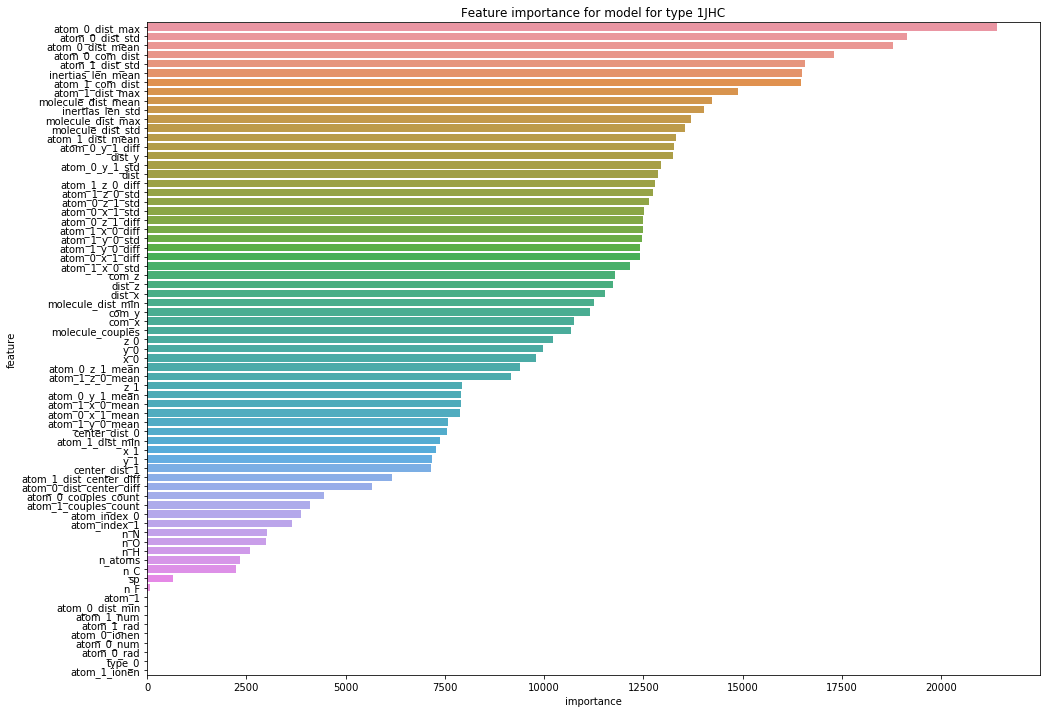

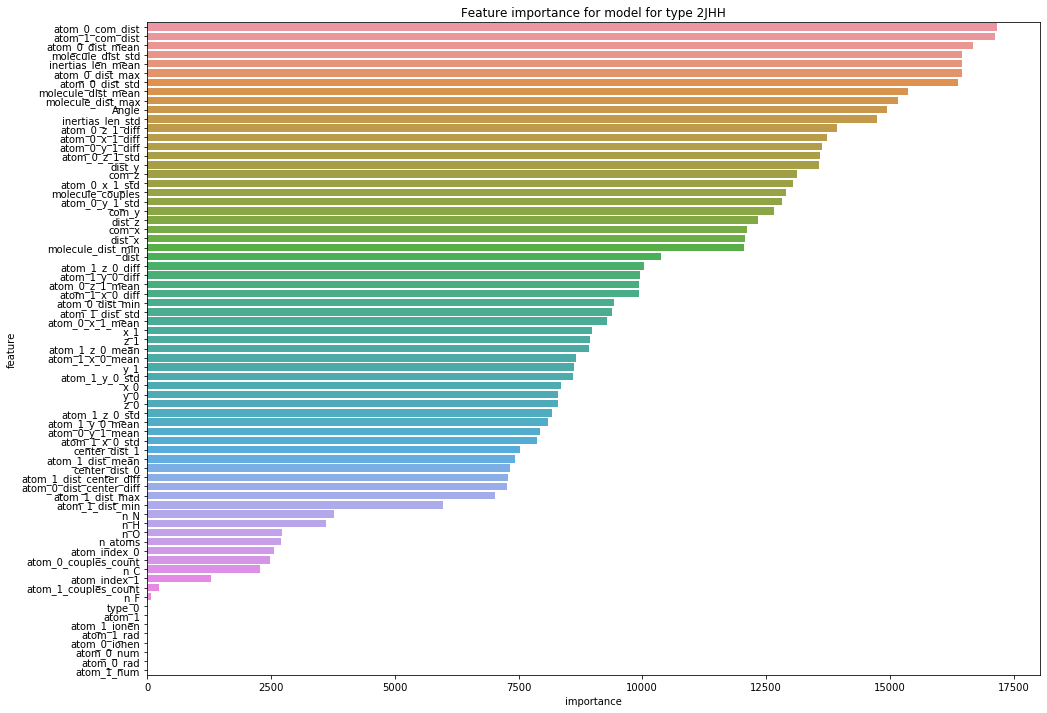

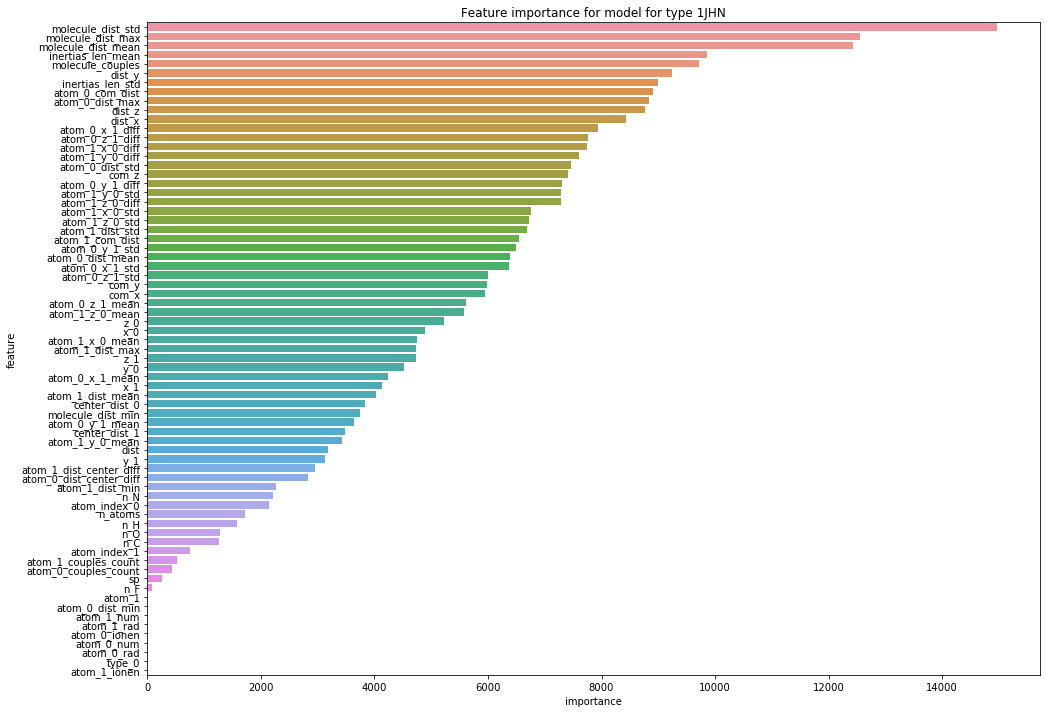

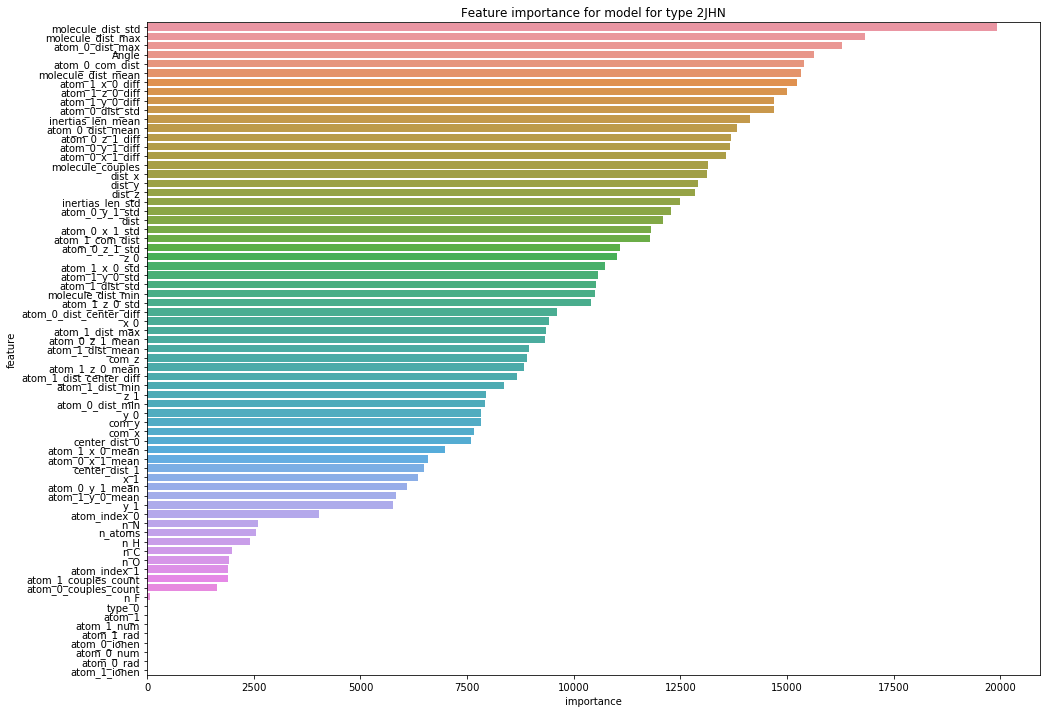

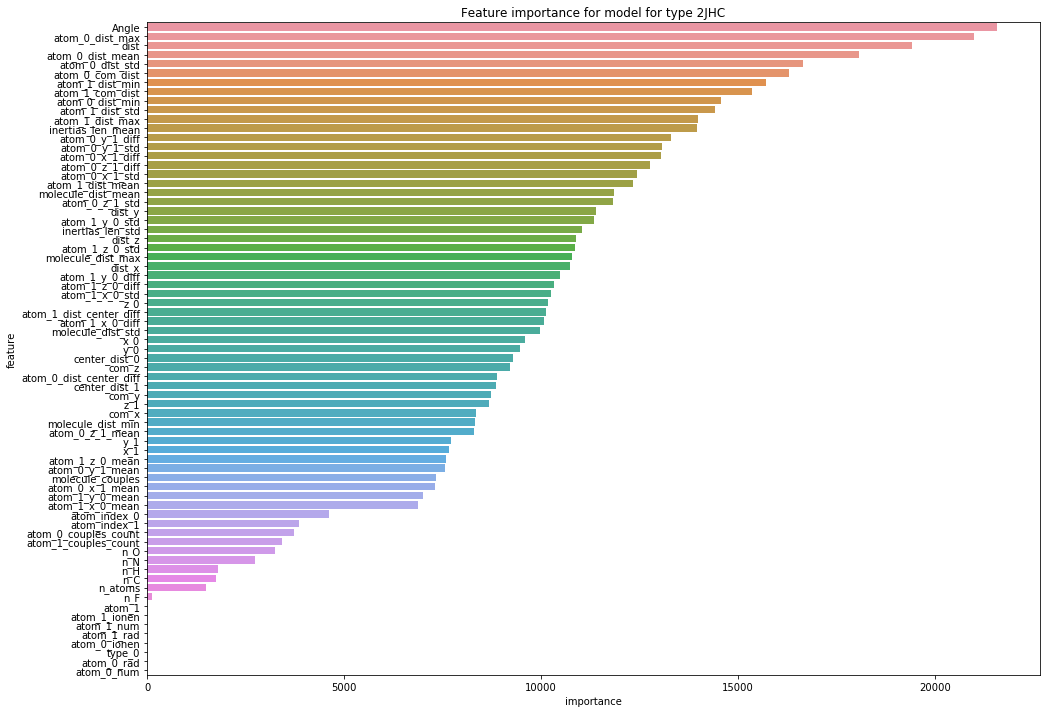

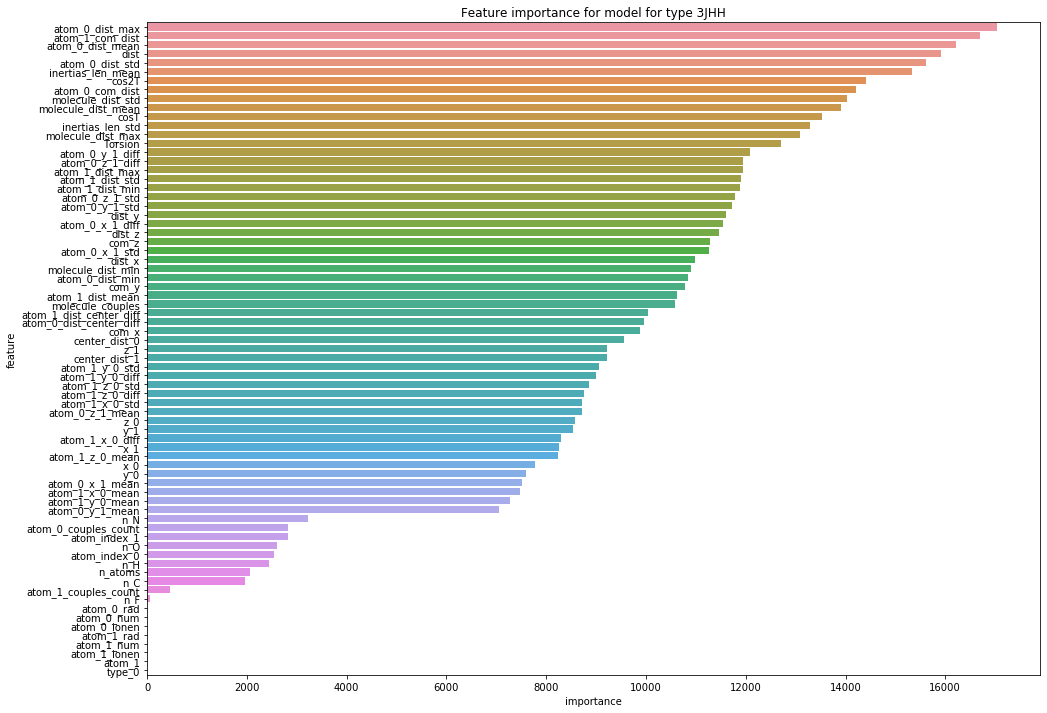

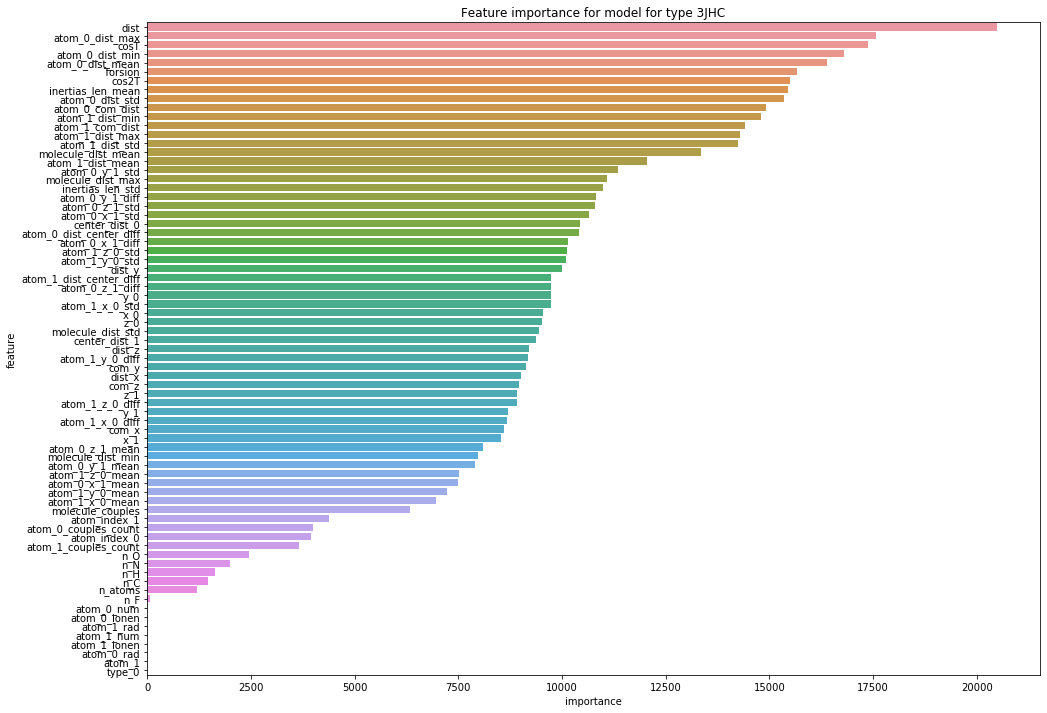

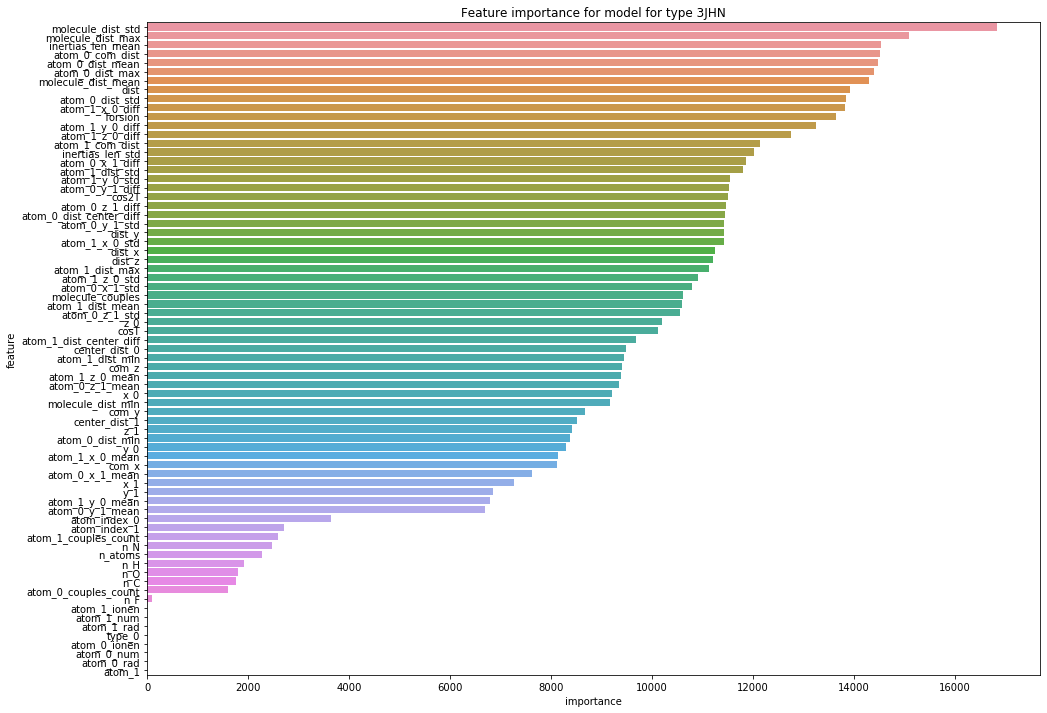

In [133]:
for model_type, model in models.items():
    if model_type[0] == '1':
        data = df.drop(['type', 'Angle', 'Torsion', 'cosT', 'cos2T', 'scalar_coupling_constant'], axis = 1)
    elif model_type[0] == '2':
        data = df.drop(['type', 'sp', 'Torsion', 'cosT', 'cos2T', 'scalar_coupling_constant'], axis = 1)
    else:
        data = df.drop(['type', 'sp', 'Angle', 'scalar_coupling_constant'], axis = 1)    
    
    plot_feature_importance(model, data, model_type)

There are a couple of things that can be taken out of these plots. First, for some bond types, there are features with high importance which are potentially harmful to generalization, because they also had high feature importance when we were doing adversarial validation. Second, some features tend to appear at the bottom of all plots and at the least are taking up a lot of memory space without having any contribution. They can safely be removed and not used in further model instances. Let's view a combined feature importance plot to make things clearer:

In [53]:
feature_importance = pd.DataFrame(columns = ['feature', 'importance'])
for model_type, model in models.items():
    if model_type[0] == '1':
        cols = df.drop(['type', 'Angle', 'Torsion', 'cosT', 'cos2T', 'scalar_coupling_constant'], axis = 1)\
                        .columns
    elif model_type[0] == '2':
        cols = df.drop(['type', 'sp', 'Torsion', 'cosT', 'cos2T', 'scalar_coupling_constant'], axis = 1)\
                        .columns
    else:
        cols = df.drop(['type', 'sp', 'Angle', 'scalar_coupling_constant'], axis = 1).columns
        
    fi = feature_importance_todf(model, cols)
    feature_importance = feature_importance.append(fi)

feature_importance = feature_importance.groupby('feature').apply(lambda x: x['importance'].sum())\
                        .reset_index().rename(columns = {0: 'importance'})

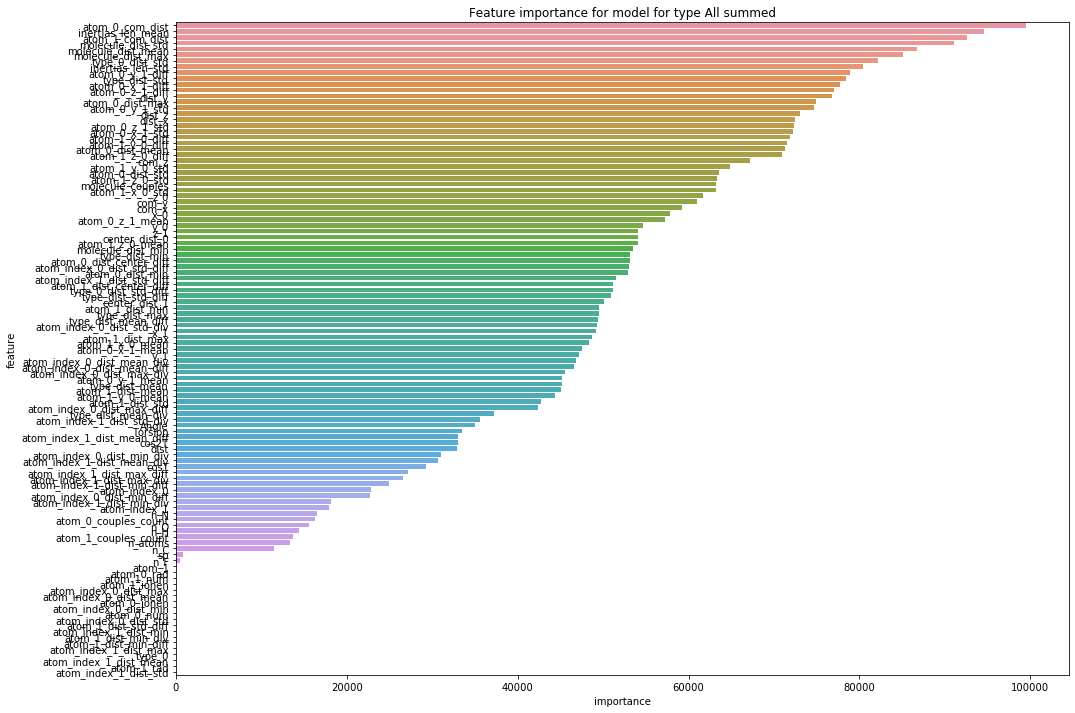

In [62]:
plot_feature_importance(None, None, 'All summed', feature_importance.importance, feature_importance.feature)

Even considering all models, some features have little or no importance. They are irrelevant to the optimization. We might as well remove them and save some RAM.

In [63]:
feature_importance[feature_importance.importance < 10]

,feature,importance
9,atom_0_ionen,0
10,atom_0_num,0
11,atom_0_rad,0
21,atom_1,0
28,atom_1_dist_min_diff,0
29,atom_1_dist_min_div,0
31,atom_1_dist_std_diff,0
32,atom_1_ionen,0
33,atom_1_num,0
34,atom_1_rad,0


In [67]:
bad_columns += feature_importance[feature_importance.importance < 10]['feature'].values.tolist()

The submission is prepared below by obtaining test set predictions from the models:

In [68]:
def prepare_test_scores(df):
    test = df[df.scalar_coupling_constant.isna()]
    test_scores = pd.DataFrame(index = test.index.tolist())
    test_scores['score'] = np.nan

    for t in df['type'].unique():
        test_indices = test[test.type == t].index.tolist()
        if t[0] == '1':     
            test_type = test[test.type == t].drop(['type', 'Angle', 'Torsion', 'cosT', 'cos2T', 'scalar_coupling_constant'],
                                                  axis = 1)
        elif t[0] == '2':
            test_type = test[test.type == t].drop(['type', 'sp', 'Torsion', 'cosT', 'cos2T', 'scalar_coupling_constant'],
                                                  axis = 1)
        else:
            test_type = test[test.type == t].drop(['type', 'sp', 'Angle', 'scalar_coupling_constant'],
                                                  axis = 1)

        test_scores.loc[test_indices, 'score'] = models[t].predict(test_type)
        
    return test_scores

In [ ]:
test_scores = prepare_test_scores(df)

The public leaderboard score this submission got was -0.838 log MAE. Let's hope we can improve on that by removing the '*bad_columns*'!

In [69]:
params = {
    'boosting': 'gbdt',
    'feature_fraction': 1.0, 
    'learning_rate': 0.1,
    'max_depth': 12,# 40
    'metric': 'mae',
    'min_child_samples': 50,
    'num_leaves': 512, #500
    'objective': 'regression',
    'reg_alpha': 0.3, #0.5
    'reg_lambda': 1.2,
    'bagging_fraction': 0.5
}

In [70]:
df = df.drop(bad_columns, axis = 1)

In [71]:
train = df[~df.scalar_coupling_constant.isna()]

models = train_models(train)

Preparing data for type 1JHC:
Training model for type 1JHC
Training until validation scores don't improve for 250 rounds.
[500]	training's l1: 1.01428	valid_1's l1: 1.50719
[1000]	training's l1: 0.699076	valid_1's l1: 1.40525
[1500]	training's l1: 0.518625	valid_1's l1: 1.36347
[2000]	training's l1: 0.400538	valid_1's l1: 1.34219
[2500]	training's l1: 0.31321	valid_1's l1: 1.32852
[3000]	training's l1: 0.248772	valid_1's l1: 1.31992
[3500]	training's l1: 0.199374	valid_1's l1: 1.31411
[4000]	training's l1: 0.161788	valid_1's l1: 1.30996
[4500]	training's l1: 0.131916	valid_1's l1: 1.30696
[5000]	training's l1: 0.107827	valid_1's l1: 1.30486
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.107827	valid_1's l1: 1.30486
Training: Done
Preparing data for type 2JHH:
Training model for type 2JHH
Training until validation scores don't improve for 250 rounds.
[500]	training's l1: 0.188539	valid_1's l1: 0.326894
[1000]	training's l1: 0.120769	valid_1's l1: 0.30844
[1500]	

Comparing the validation scores before removing the '*bad*' features and now, we should expect an improvement in the test score (hopefully...if the validation sets are any good). Predicting the test set results and creating the submission csv file:

In [72]:
test = df[df.scalar_coupling_constant.isna()]
test_scores = pd.DataFrame(index = test.index.tolist())
test_scores['score'] = np.nan

for t in df['type'].unique():
    test_indices = test[test.type == t].index.tolist()
    if t[0] == '1':     
        test_type = test[test.type == t].drop(['type', 'Angle', 'Torsion', 'cosT', 'cos2T', 'scalar_coupling_constant'],
                                              axis = 1)
    elif t[0] == '2':
        test_type = test[test.type == t].drop(['type', 'sp', 'Torsion', 'cosT', 'cos2T', 'scalar_coupling_constant'],
                                              axis = 1)
    else:
        test_type = test[test.type == t].drop(['type', 'sp', 'Angle', 'scalar_coupling_constant'],
                                              axis = 1)
        
    test_scores.loc[test_indices, 'score'] = models[t].predict(test_type)

In [73]:
molecular_coupling = 'molecular_coup_sub_2_postadv.csv'
scores = test_scores.reset_index().rename(columns={'index': 'id', 'score': 'scalar_coupling_constant'})
scores[['id', 'scalar_coupling_constant']].to_csv(molecular_coupling, index= False)

print('CSV Created: Done')    

CSV Created: Done


The public leaderboard score for this submission is -0.851 log MAE, which is an improvement (albeit slight)!

## 7. Parting Notes
The "Predicting Molecular Properties" competition is a good test for anyone's feature engineering skills. The only data given are .xyz files with Cartesian coordinates of atoms within molecules, plus the type of atom it is (e.g. carbon, hydrogen etc.). It was really interesting having to dig in a bit of organic chemistry to come up with useful features. I'll admit I barely understood anything (chemistry wasn't my strongest subject in school), but I did get some hints out of it and it was an overall challenging, yet fun experience.

## 8. Conclusion
One slightly disappointing side to this competition, for me, was that midway through the competition, the use of some quantum computations was allowed (since a lot of people were cheating and trying to use them). I hate this mindset of trying to win for the sake of winning and not actually concentrating on the practicality of it all. The aim of this competition is to come up with a model that approximates the scalar coupling constant, therefore **avoids** the use of heavy quantum computations. For me, this makes the competition one of ego and not of purpose, so I have not used the available and, as of now, allowed quantum computations, probably at the cost of significantly higher results. My final result was -0.851 log mean absolute error which, at the time of writing this notebook put me in the top 25%. It's not an impressive result, though I am content with it, considering that the competition mostly consists of experienced professionals and I am a (still amateur) beginner.

## 9. References
1. https://www.kaggle.com/adrianoavelar/eachtype
2. https://www.kaggle.com/artgor/validation-feature-selection-interpretation-etc
3. https://www.kaggle.com/c/champs-scalar-coupling/discussion/96020#latest-557968
4. https://www.kaggle.com/jmtest/molecule-with-openbabel
5. https://www.kaggle.com/robertburbidge/atomic-properties
6. Reich J., 2018, University of Wisconsin, **_6-CMR-5 One-Bond Carbon-Proton Coupling (1JCH)_** https://www.chem.wisc.edu/areas/reich/nmr/06-cmr-05-1jch.htm
7. Banks R., May 2002, **_Bonding and Hybridization_**, https://chemistry.boisestate.edu/richardbanks/inorganic/bonding%20and%20hybridization/bonding_hybridization.htm
8. Wikipedia, 8 June 2019, **_J-coupling_**, https://en.wikipedia.org/wiki/J-coupling
9. Reich J., 2017, University of Wisconsin, **_Spin-Spin Splitting: J-Coupling_**, https://www.chem.wisc.edu/areas/reich/nmr/Notes-05-HMR-v26-part2.pdf